In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
tf.enable_eager_execution()


import math
import os
import sys
sys.path.append("/home/darth/projects/bopt")
sys.path.append("/Users/arnoljak/projects/bopt")

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

import bopt

from bopt.kernels.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from bopt.models.gaussian_process_regressor import GaussianProcessRegressor
from bopt.bayesian_optimization import bo_plot_exploration, bo_maximize_loop, Integer, Float
from bopt.bayesian_optimization import plot_2d_optim_result
# from bopt.acquisition_functions import expected_improvement, probability_of_improvement
# from bopt.bayesian_optimization import propose_location
# from bopt.opt_functions import get_opt_test_functions
from bopt.plot import plot_gp, plot_kernel_loss, plot_kernel_loss_2d

import GPy
import sklearn.gaussian_process as skproc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


/home/darth/projects/bopt/.venv/lib/python3.6/site-packages/GPy/util/config.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/darth/projects/bopt/.venv/lib/python3.6/site-packages/GPy/defaults.cfg' mode='r' encoding='UTF-8'>
  config.readfp(open(default_file))
/home/darth/projects/bopt/.venv/lib/python3.6/site-packages/GPy/util/datasets.py:58: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/darth/projects/bopt/.venv/lib/python3.6/site-packages/GPy/util/data_resources.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()
/home/darth/projects/bopt/.venv/lib/python3.6/site-packages/GPy/util/datasets.py:63: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/darth/projects/bopt/.venv/lib/python3.6/site-packages/GPy/util/football_teams.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()


# Test datasets

In [67]:
import yaml

In [70]:
with open("gen_datasets.yml", "r") as f:
    datasets = yaml.load(f)

In [73]:
X_train, y_train, X = datasets[1]

## Broken kernel


In [12]:
def kernel_plot(lbfgs = False, use_tf = False):
    bopt.clear_param_traces()
    os.environ["USE_LBFGS"] = "1" if lbfgs else "0"
    os.environ["USE_TF"] = "1" if use_tf else "0"

    gp = bopt.GaussianProcessRegressor(kernel=result.kernel) \
        .fit(X, y) \
        .optimize_kernel()
    
    plt.figure(figsize=(16, 5))
    U_LB = os.environ.get("USE_LBFGS", False)
    U_TF = os.environ.get("USE_TF", False)

    plt.suptitle(f"LBFGS={U_LB} TF={U_TF}   noise={round(gp.noise, 2)} {gp.kernel}", fontsize=20)

    plt.subplot(131)
    bopt.plot_2d_optim_result(result, gp=gp)
    
    param_traces = bopt.kernel_opt.get_param_traces()

    nll_trace = param_traces["nll"]
    param_traces.pop("nll")

    plt.subplot(132)
    for name, vals in param_traces.items():
        plt.plot(vals, label=name)
    plt.subplot(133)
    plt.plot(nll_trace)
    plt.show()

In [74]:
meta_dir = "results/mc"

exp = bopt.Experiment.deserialize(meta_dir)
result = exp.current_optim_result(meta_dir)

X = result.X_sample
y = result.y_sample

y = (y - y.mean()) / y.std()

1.034389    0.622220    0.918791    4.696565
0.890236    0.447176    1.025305    4.476174
0.784860    0.339597    1.044178    4.393554
0.686553    0.270660    1.034334    4.347515
0.587640    0.224203    1.022742    4.319492
0.485256    0.191783    1.014910    4.301485
0.376637    0.168702    1.009480    4.288551
0.260912    0.152631    1.004443    4.276765
0.156092    0.143426    0.997580    4.263610
0.105380    0.140617    0.991530    4.257894
0.090332    0.140068    0.990403    4.257144
0.083919    0.139880    0.990297    4.256978
0.080117    0.139777    0.990256    4.256914
0.077486    0.139709    0.990240    4.256883
0.075505    0.139660    0.990234    4.256864
0.073932    0.139622    0.990231    4.256853
0.072635    0.139591    0.990229    4.256845
0.071537    0.139565    0.990229    4.256840
0.070587    0.139544    0.990229    4.256835
0.069753    0.139525    0.990230    4.256832
0.069010    0.139508    0.990230    4.256830
0.068342    0.139493    0.990231    4.256828
0.067735  

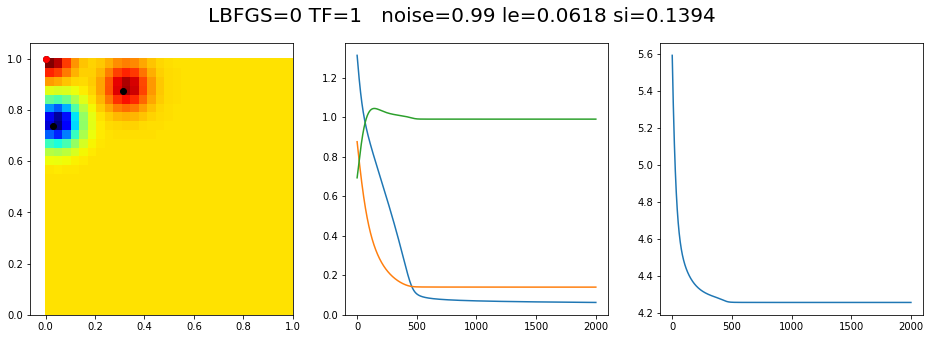

1.211184    0.003839    0.998451    4.256844
1.136319    0.000012    1.000015    4.256816
0.022669    0.000010    1.000000    4.256816
...le=0.0227 si=0.0 0.9999999999500065 nll=4.26


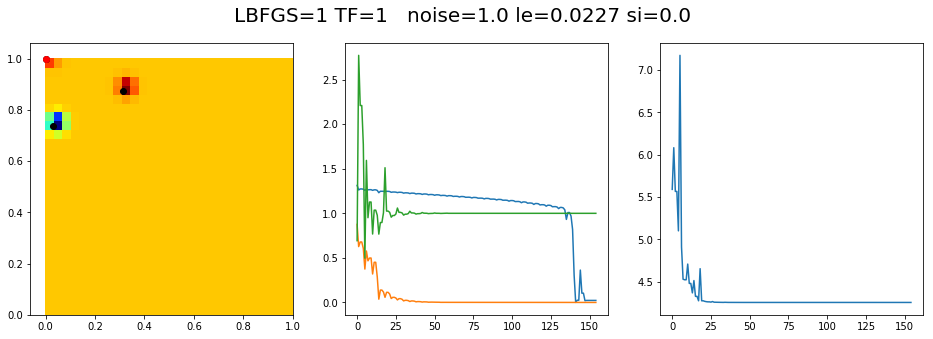

0.805636    0.025565    1.000631    4.257742
...le=0.8247 si=0.0042 0.9992328079351535 nll=4.26


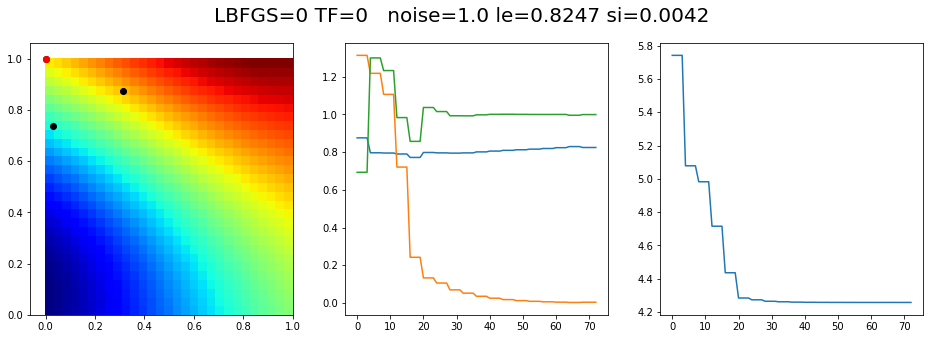

In [75]:
kernel_plot(use_tf=True, lbfgs=False)
kernel_plot(use_tf=True, lbfgs=True)
kernel_plot(use_tf=False)

-4.256820221343807


 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fb1846c4d68>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fb1846c4c88>]}

 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


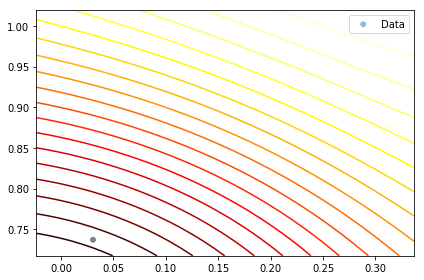

In [58]:
rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X, y.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpr.plot()

-4.256820221343807
...le=0.2998 si=0.0022 0.9999988859211096 nll=4.26


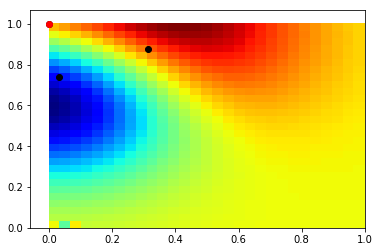

In [59]:
rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X, y.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpy_params = {
    "noise": float(gpr.Gaussian_noise.variance),
    "ls": gpr.rbf.lengthscale.values[0],
    "sigma": np.sqrt(gpr.rbf.variance.values[0])
}

gp = GaussianProcessRegressor(noise=math.sqrt(gpy_params["noise"]),
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
                    .fit(X, y)

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()


# 1d comparison with GPy

In [47]:
def model_bopt():
    gp = GaussianProcessRegressor(noise=1.0, kernel=SquaredExp(l=1.0, sigma=1.0)).fit(X_train, y_train)\
      .optimize_kernel().posterior(X)
    
    params = {
        "noise": gp.noise,
        "ls": gp.kernel.params["lengthscale"].numpy().item(),
        "sigma": gp.kernel.params["sigma"].numpy().item()
    }
    
    print(params)
    return gp.mu, gp.cov, params, gp.log_prob().numpy().item()

    
def model_gpy():
    # {'noise': 0.4832512948800222, 'ls': 1.5587106910395732, 'sigma': 3.8447816296081188}
    rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
    gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

    gpr.optimize(max_iters=5000)
    print("####################################\n\n")
    
    mu, cov = gpr.predict(X, full_cov=True)
    
    params = {
        "noise": float(np.sqrt(gpr.Gaussian_noise.variance)),
        "ls": gpr.rbf.lengthscale.values[0],
        "sigma": np.sqrt(gpr.rbf.variance.values[0])
    }
    
    nll = -gpr.log_likelihood()
    
    print(params)
    return mu.reshape(-1), cov, params, nll

In [48]:
params = [0.1, 0.3]

X_train = np.array([2,2.5,20,100], dtype=np.float64).reshape(-1, 1)
y_train = np.array([2,3,2,5], dtype=np.float64)

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.1).reshape(-1, 1)

98.182527    3.395776    0.788409    8.069299
161.880319    3.867540    0.796012    7.945532
{'noise': 0.7960123863552826, 'ls': 161.88031918082342, 'sigma': 3.8675399045433365}



####################################


{'noise': 0.7959051924751378, 'ls': 161.82266677239917, 'sigma': 3.8665475062518766}


 /home/darth/projects/bopt/bopt/plot.py:79: RuntimeWarning:covariance is not symmetric positive-semidefinite.


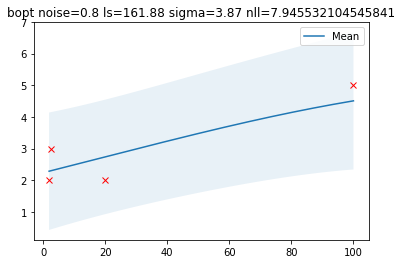

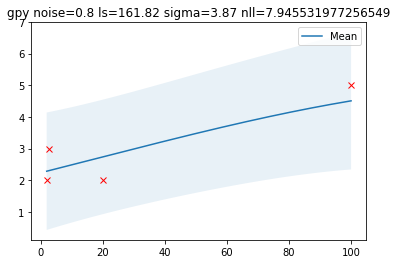

In [49]:
xxx = model_bopt()
print("\n\n")
yyy = model_gpy()

model_options = [
    ("bopt", xxx),
    ("gpy", yyy)
]

for name, (mu, cov, params, nll) in model_options:
#     mu, cov, params = model()

    param_str = " ".join([f"{name}={round(value, 2)}" for name, value in params.items()])
    
    plt.figure()
    plt.title(name + " " + param_str + f" nll={nll}")
    plot_gp(mu.reshape(-1), cov, X.reshape(-1), X_train.reshape(-1),
            y_train.reshape(-1), num_samples=0, figure=False)

5.6863674233819046e-27

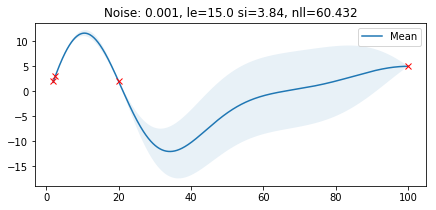

In [50]:
lp = GaussianProcessRegressor(noise=.001, kernel=SquaredExp(l=15, sigma=3.84)).fit(X_train, y_train)\
      .posterior(X).plot_posterior(num_samples=0).log_prob()
np.exp(-lp.numpy())

9.402437702967065e-05

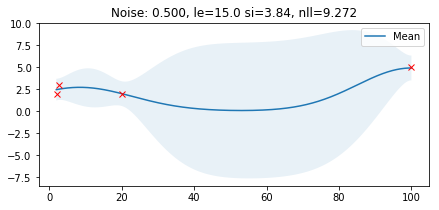

In [51]:
lp = GaussianProcessRegressor(noise=0.5, kernel=SquaredExp(l=15, sigma=3.84)).fit(X_train, y_train)\
      .posterior(X).plot_posterior(num_samples=0).log_prob()
np.exp(-lp.numpy())

In [52]:
GaussianProcessRegressor(noise=1.48, kernel=SquaredExp(l=1.56, sigma=3.84)).fit(X_train, y_train)\
      .log_prob()

<tf.Tensor: id=5410165, shape=(), dtype=float64, numpy=9.902058590895589>

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fb1b8383518>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fb1f03f5198>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fb1f03edcf8>]}

 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


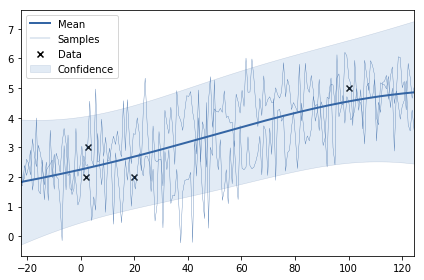

In [53]:
# rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
rbf = GPy.kern.Matern52(input_dim=1)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
gpr.plot(samples=2)

####################################


{'noise': 0.7959051924751378, 'ls': 161.82266677239917, 'sigma': 3.8665475062518766}


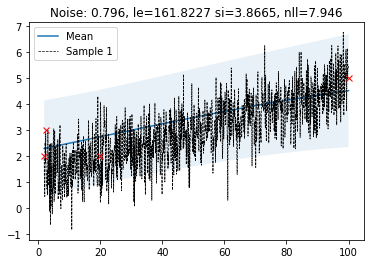

In [54]:
def gpy_to_bopt():
    _, _, gpy_params, nll = model_gpy()

    gp = GaussianProcessRegressor(noise=gpy_params["noise"],
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
      .fit(X_train, y_train)
    
    return gp

# BOPT plot using exactly the same GPY params
gpy_to_bopt().posterior(X).plot_posterior(figsize=(6,4), num_samples=1)

####################################


{'noise': 0.7959051924751378, 'ls': 161.82266677239917, 'sigma': 3.8665475062518766}
98.182527    3.395776    0.788409    8.069299
162.285913    3.870957    0.795928    7.945536
{'noise': 0.7960123863552826, 'ls': 161.88031918082342, 'sigma': 3.8675399045433365}
shapes (982,) (982,) (982, 982) (982, 982)
max mean diff 9.47146966758794e-05
nll diff 1.272892919956803e-07

c diff 0.0002950344980048314


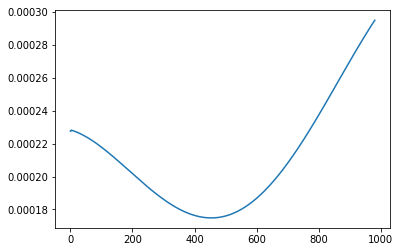

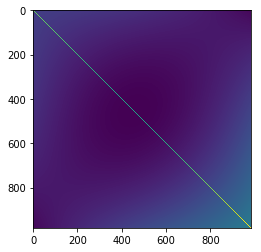

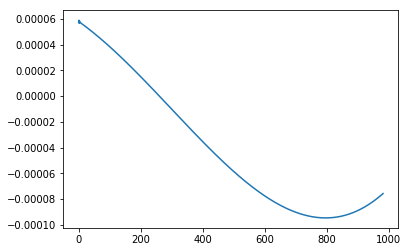

In [55]:
m2, c2, _, nll2 = model_gpy()
m1, c1, _, nll1 = model_bopt()

np.allclose(c1, c2, atol=1e-5), np.allclose(m1, m2, atol=1e-5)

print("shapes", m1.shape, m2.shape, c1.shape, c2.shape)

print("max mean diff", np.max(np.abs(m1 - m2)))
print("nll diff", np.max(np.abs(nll1 - nll2)))
print()
print("c diff", np.max(np.abs(c1 - c2)))
plt.plot(np.diag(c1 - c2))
plt.show()
plt.imshow(c1 - c2)
plt.show()

plt.plot(m1 - m2)
# np.diag(c1 - c2)

## 2d data - BOPT vs GPY

0.771946    0.242601    0.857111    4.435232
0.824682    0.004200    0.999233    4.256842
...le=0.8247 si=0.0042 0.9992328079351535 nll=4.26


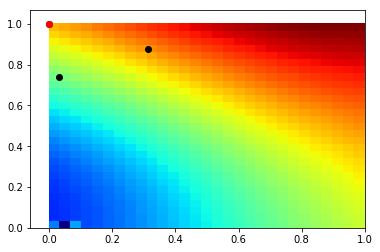

-4.256820221343807
...le=0.2998 si=0.0022 0.9999977718434605 nll=4.26


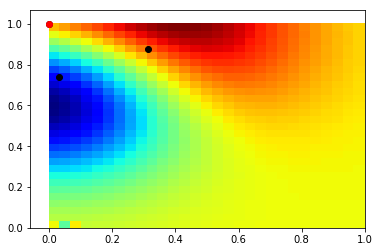

In [44]:
meta_dir = "results/mc"

exp = bopt.Experiment.deserialize(meta_dir)
result = exp.current_optim_result(meta_dir)

X_train = result.X_sample
y_train = result.y_sample

y_train = (y_train - y_train.mean()) / y_train.std()

model_options = [
    ("bopt", model_bopt),
    ("gpy", model_gpy)
]

gp = bopt.GaussianProcessRegressor(kernel=result.kernel) \
    .fit(X_train, y_train) \
    .optimize_kernel()

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()

rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpy_params = {
    "noise": float(gpr.Gaussian_noise.variance),
    "ls": gpr.rbf.lengthscale.values[0],
    "sigma": np.sqrt(gpr.rbf.variance.values[0])
}

gp = GaussianProcessRegressor(noise=gpy_params["noise"],
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
        .fit(X_train, y_train)

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()

# for name, model in model_options:
#     mu, cov, params = model()
    
#     param_str = " ".join([f"{name}={round(value, 2)}" for name, value in params.items()])
    
#     plt.figure()
#     plt.title(name + " " + param_str)
# #    plot_gp(mu.reshape(-1), cov, X.reshape(-1), X_train.reshape(-1),
# #            y_train.reshape(-1), num_samples=1, figure=False)

-4.256820221343807


 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fb1f0101b70>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fb1f02f0a90>]}

 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


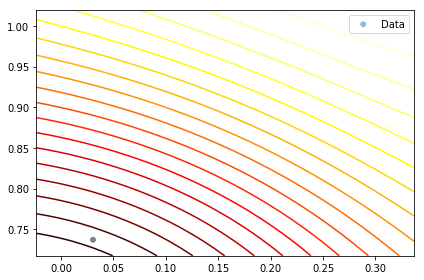

In [11]:
rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpr.plot()

In [ ]:
## useless

def model_sklearn():
    rbf = skproc.kernels.ConstantKernel(1.0) \
            * skproc.kernels.RBF(length_scale=1.0) \
            * skproc.kernels.WhiteKernel(1.0)

    gpr = skproc.GaussianProcessRegressor(kernel=rbf, alpha=1.)
    gpr.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

    mu, cov = gpr.predict(X.reshape(-1, 1), return_cov=True)

    kernel_sigma = gpr.kernel_.k1.k1
    kernel_ls = gpr.kernel_.k1.k2
    kernel_noise = gpr.kernel_.k2
    
    params = {
        "noise": kernel_noise.noise_level,
        "ls": kernel_ls.length_scale,
        "sigma": np.sqrt(kernel_sigma.constant_value)
    }
    
    return mu, cov, params

In [10]:
rbf.K(X_train.reshape(-1, 1), X_train.reshape(-1, 1))

array([[14.78248556, 14.78218135, 12.03294434],
       [14.78218135, 14.78248556, 12.0823241 ],
       [12.03294434, 12.0823241 , 14.78248556]])

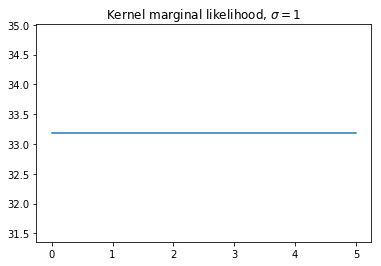

In [11]:
class GPyWrapper:
    def __init__(self):
        self.params = None
        
    def set_params(self, params):
        self.params = params
        return self
        
    def __call__(self, a, b):
        return GPy.kern.RBF(input_dim=1, variance=1., lengthscale=params[0]).K(a.reshape(-1, 1), b.reshape(-1, 1))

plot_kernel_loss(GPyWrapper(), X_train, y_train)

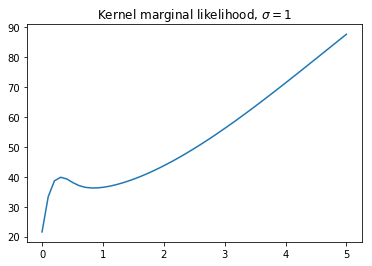

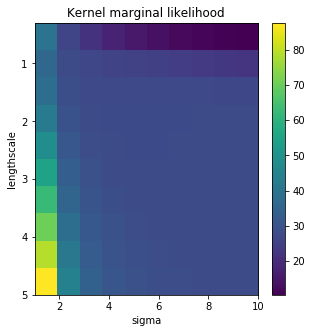

In [12]:
kernel = SquaredExp(sigma=0.001)
plot_kernel_loss(kernel, X_train, y_train)
plot_kernel_loss_2d(kernel, X_train, y_train)

# Big data

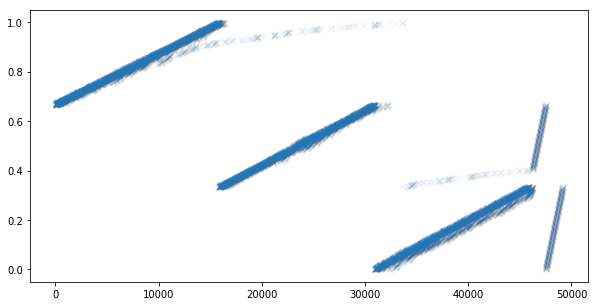

In [15]:
values = np.genfromtxt("../data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [16]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

In [17]:
def fit_with_scale(X, y, scale):
    y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
    X = np.array(list(range(len(y)))) / scale

    gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
    gp.plot_posterior(num_samples=0)


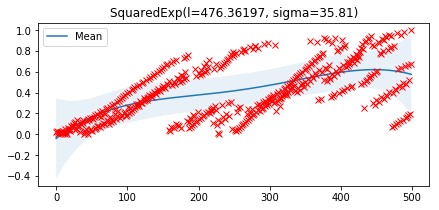

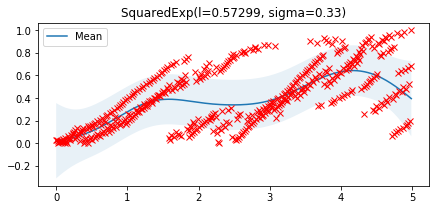

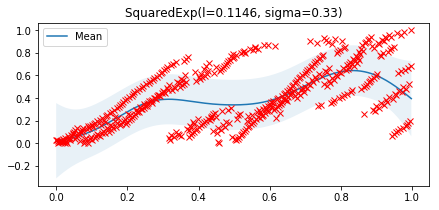

In [18]:
def foo():
    for i in [1,100, 500]:
        fit_with_scale(X, y, i)
        plt.show()
        
%prun foo()

# TODO Gaussian likelihood for a given covariance

# TODO Gaussian likelihood for a given covariance

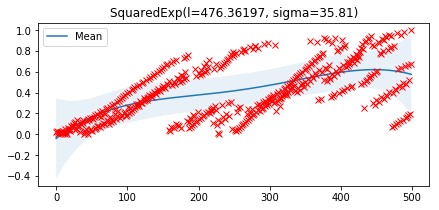

In [19]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

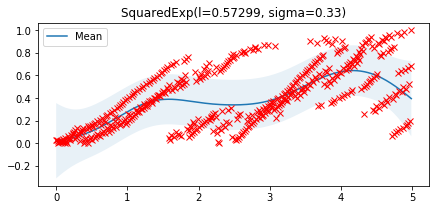

In [20]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

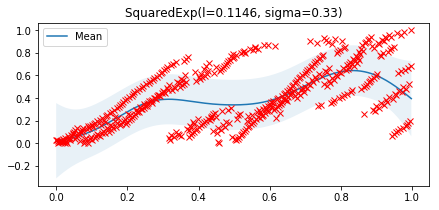

In [21]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

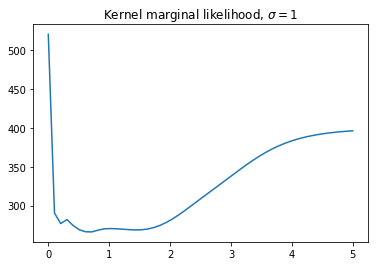

In [22]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

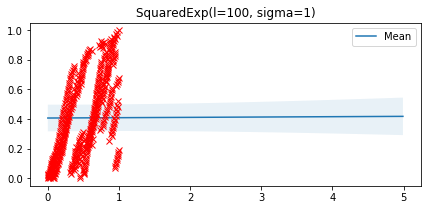

In [23]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)

## Stare data

In [138]:
noise = 1

params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])

X_train = np.array([2,2.01,3], dtype=np.float64).reshape(-1, 1)  #, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5], dtype=np.float64)

# X_train = np.array([2,2.01,2.02,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
# y_train = np.array([2,3,2,100])

# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01).reshape(-1, 1)